In [11]:
# === Cell 1: Imports, Seeding, Device & Plot Directory
import torch, random, numpy as np
import torch.nn as nn, torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, Subset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import seaborn as sns
import os


SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


plot_dir = "/mnt/data/nma_plots"
os.makedirs(plot_dir, exist_ok=True)


sns.set(style="darkgrid")
plt.style.use('dark_background')
plt.rcParams.update({
    'axes.facecolor': '#121212',
    'axes.edgecolor': '#00FF41',
    'axes.labelcolor': '#00FF41',
    'xtick.color': '#00FF41',
    'ytick.color': '#00FF41',
    'grid.color': '#004400',
    'grid.linestyle': '--',
    'figure.facecolor': '#121212',
    'text.color': '#00FF41',
    'lines.linewidth': 2,
    'lines.markersize': 6,
    'font.size': 12,
})

Using device: cuda


In [12]:


from torch.utils.data import Subset
from torchvision.datasets import MNIST
from torchvision import transforms


transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])


full_train = MNIST(".", train=True, download=True, transform=transform)
test_ds = MNIST(".", train=False, download=True, transform=transform)


full_indices = list(range(len(full_train)))
random.seed(SEED)
random.shuffle(full_indices)


split_idx = int(0.8 * len(full_indices))
train_idx_full = full_indices[:split_idx]
val_idx_full = full_indices[split_idx:]


train_idx = train_idx_full[::2]
val_idx = val_idx_full[::2]

train_ds = Subset(full_train, train_idx)
val_ds = Subset(full_train, val_idx)


BATCH = 128
train_loader = DataLoader(train_ds, batch_size=BATCH, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=BATCH, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=BATCH, shuffle=False)


print(f"Final Dataset sizes — Train: {len(train_ds)}, Val: {len(val_ds)}, Test: {len(test_ds)}")


Final Dataset sizes — Train: 24000, Val: 6000, Test: 10000


In [13]:


class FFN(nn.Module):
    def __init__(self, inp, hid, out):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(inp, hid),
            nn.ReLU(),
            nn.Linear(hid, out)
        )
    def forward(self, x):
        return self.net(x)

In [14]:

INPUT_SIZE = 28*28
HIDDEN_SIZE = 128
NUM_CLASSES = 10
LR = 1e-3
EPOCHS = 8

def make_models():

    torch.manual_seed(SEED)
    np.random.seed(SEED)
    random.seed(SEED)
    m_bp = FFN(INPUT_SIZE, HIDDEN_SIZE, NUM_CLASSES).to(device)
    torch.manual_seed(SEED)
    np.random.seed(SEED)
    random.seed(SEED)
    m_fa = FFN(INPUT_SIZE, HIDDEN_SIZE, NUM_CLASSES).to(device)
    torch.manual_seed(SEED)
    np.random.seed(SEED)
    random.seed(SEED)
    B = torch.randn(NUM_CLASSES, HIDDEN_SIZE, device=device) * 0.1
    return m_bp, m_fa, B


In [15]:
# === Cell 5: Update Functions (BP & FA)
def bp_update(model, X, y, opt, crit):
    model.train()
    opt.zero_grad()
    logits = model(X)
    loss = crit(logits, y)
    loss.backward()
    opt.step()
    return loss.item()

def fa_update(model, X, y, B):
    """
    Feedback‐Alignment update that now correctly applies the ReLU derivative
    on the hidden layer pre‐activations.
    """
    model.train()

    # flatten, forward to hidden pre‐activation and activation
    x_flat = X.view(X.size(0), -1)
    h_pre  = model.net[1](x_flat)      # Linear
    h      = model.net[2](h_pre)       # ReLU
    logits = model.net[3](h)           # final linear

    # compute output error
    y_onehot = torch.zeros_like(logits).scatter_(1, y.unsqueeze(1), 1.0)
    probs    = torch.softmax(logits, dim=1)
    e_out    = y_onehot - probs

    # back‐project through fixed random B, *then* mask by ReLU′(h_pre)
    e_hid = (e_out @ B) * (h_pre > 0).float()

    # grab weights & biases
    W2, W1 = model.net[3].weight, model.net[1].weight
    b2, b1 = model.net[3].bias,   model.net[1].bias

    batch_size = X.size(0)
    # compute updates
    dW2 = (e_out.t() @ h)       * (LR / batch_size)
    dW1 = (e_hid.t() @ x_flat)  * (LR / batch_size)
    db2 = e_out.sum(0)          * (LR / batch_size)
    db1 = e_hid.sum(0)          * (LR / batch_size)

    # apply them
    with torch.no_grad():
        W2.add_(dW2)
        W1.add_(dW1)
        b2.add_(db2)
        b1.add_(db1)

    return F.cross_entropy(logits, y).item()


In [16]:

# === Cell 6: Train/Validation Functions
def evaluate(model, loader, crit=None):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for X, y in loader:
            X, y = X.to(device), y.to(device)
            logits = model(X)
            if crit:
                total_loss += crit(logits, y).item() * X.size(0)
            pred = logits.argmax(dim=1)
            correct += (pred == y).sum().item()
            total += y.size(0)
    avg_loss = total_loss / total if crit else None
    acc = correct / total
    return avg_loss, acc

def train_epoch_bp(model, loader, opt, crit):
    model.train()
    losses = []
    batch_lrs = []
    for X, y in loader:
        X, y = X.to(device), y.to(device)
        loss = bp_update(model, X, y, opt, crit)
        losses.append(loss)
        batch_lrs.append(opt.param_groups[0]['lr'])
    return np.mean(losses), batch_lrs

def train_epoch_fa(model, loader, B, crit):
    model.train()
    losses = []
    for X, y in loader:
        X, y = X.to(device), y.to(device)
        loss = fa_update(model, X, y, B)
        losses.append(loss)
    return np.mean(losses)


In [17]:
#=== Updated Cell 7: Training Loop with Integrated Bias & Variance (SNR) Metrics

m_bp, m_fa, B = make_models()
opt_bp = optim.Adam(m_bp.parameters(), lr=LR)
crit = nn.CrossEntropyLoss()
layers = [name for name, _ in m_bp.named_parameters() if ('weight' in name or 'bias' in name)]

metrics = {
    'bp': {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': [], 'batch_loss': [], 'batch_lr': []},
    'fa': {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': [], 'batch_loss': []}
}

bias_curve = {layer: [] for layer in layers}
snr_curve = {layer: [] for layer in layers}

print("Starting training...\n")
for epoch in range(1, EPOCHS + 1):

    # For accumulating weight update stats per layer
    stats = {layer: {'sum_bp': None, 'sum_fa': None, 'sq_bp': None, 'sq_fa': None, 'cnt': 0} for layer in layers}

    bp_losses = []
    bp_batch_lrs = []
    fa_losses = []

    for i, (X, y) in enumerate(train_loader):
        X, y = X.to(device), y.to(device)

        # Save weights before updates for BP and FA
        before_bp = {name: p.clone() for name, p in m_bp.named_parameters() if name in layers}
        before_fa = {name: p.clone() for name, p in m_fa.named_parameters() if name in layers}

        # BP update
        loss_bp = bp_update(m_bp, X, y, opt_bp, crit)
        bp_losses.append(loss_bp)
        bp_batch_lrs.append(opt_bp.param_groups[0]['lr'])

        # FA update
        loss_fa = fa_update(m_fa, X, y, B)
        fa_losses.append(loss_fa)

        # Accumulate weight update stats (only for first 40 batches for stability)
        if i < 40:
            with torch.no_grad():
                for layer in layers:
                    d_bp = (m_bp.state_dict()[layer] - before_bp[layer]).flatten().cpu().numpy()
                    d_fa = (m_fa.state_dict()[layer] - before_fa[layer]).flatten().cpu().numpy()

                    s = stats[layer]
                    if s['sum_bp'] is None:
                        s['sum_bp'] = np.zeros_like(d_bp)
                        s['sum_fa'] = np.zeros_like(d_fa)
                        s['sq_bp'] = np.zeros_like(d_bp)
                        s['sq_fa'] = np.zeros_like(d_fa)
                    s['sum_bp'] += d_bp
                    s['sum_fa'] += d_fa
                    s['sq_bp'] += d_bp**2
                    s['sq_fa'] += d_fa**2
                    s['cnt'] += 1

    # Compute bias (cosine similarity) and SNR per layer for this epoch
    def normalize_vec(v):
        norm = np.linalg.norm(v)
        return v / norm if norm > 1e-12 else v

    for layer in layers:
        s = stats[layer]
        cnt = s['cnt'] if s['cnt'] > 0 else 1  # avoid div by zero
        μ_bp = s['sum_bp'] / cnt
        μ_fa = s['sum_fa'] / cnt
        var_bp = s['sq_bp'] / cnt - μ_bp**2
        var_fa = s['sq_fa'] / cnt - μ_fa**2

        μ_bp_n = normalize_vec(μ_bp)
        μ_fa_n = normalize_vec(μ_fa)

        cosine_sim = np.dot(μ_bp_n, μ_fa_n)
        bias_curve[layer].append(cosine_sim)

        snr_bp = np.dot(μ_bp, μ_bp) / (np.sum(var_bp) + 1e-12)
        snr_fa = np.dot(μ_fa, μ_fa) / (np.sum(var_fa) + 1e-12)
        snr_curve[layer].append((snr_bp, snr_fa))

    # Evaluate on validation and training sets
    bp_val_loss, bp_val_acc = evaluate(m_bp, val_loader, crit)
    bp_train_acc = evaluate(m_bp, train_loader)[1]

    fa_val_loss, fa_val_acc = evaluate(m_fa, val_loader, crit)
    fa_train_acc = evaluate(m_fa, train_loader)[1]

    metrics['bp']['train_loss'].append(np.mean(bp_losses))
    metrics['bp']['val_loss'].append(bp_val_loss)
    metrics['bp']['train_acc'].append(bp_train_acc)
    metrics['bp']['val_acc'].append(bp_val_acc)
    metrics['bp']['batch_loss'].extend([np.mean(bp_losses)] * len(train_loader))
    metrics['bp']['batch_lr'].extend(bp_batch_lrs)

    metrics['fa']['train_loss'].append(np.mean(fa_losses))
    metrics['fa']['val_loss'].append(fa_val_loss)
    metrics['fa']['train_acc'].append(fa_train_acc)
    metrics['fa']['val_acc'].append(fa_val_acc)
    metrics['fa']['batch_loss'].extend([np.mean(fa_losses)] * len(train_loader))

    print(f"Epoch {epoch:02d} | BP train acc: {bp_train_acc:.3f}, val acc: {bp_val_acc:.3f} | "
          f"FA train acc: {fa_train_acc:.3f}, val acc: {fa_val_acc:.3f}")


Starting training...

Epoch 01 | BP train acc: 0.934, val acc: 0.919 | FA train acc: 0.170, val acc: 0.170
Epoch 02 | BP train acc: 0.957, val acc: 0.943 | FA train acc: 0.393, val acc: 0.394
Epoch 03 | BP train acc: 0.970, val acc: 0.950 | FA train acc: 0.579, val acc: 0.572
Epoch 04 | BP train acc: 0.975, val acc: 0.954 | FA train acc: 0.695, val acc: 0.687
Epoch 05 | BP train acc: 0.978, val acc: 0.959 | FA train acc: 0.758, val acc: 0.746
Epoch 06 | BP train acc: 0.984, val acc: 0.959 | FA train acc: 0.789, val acc: 0.777
Epoch 07 | BP train acc: 0.989, val acc: 0.963 | FA train acc: 0.812, val acc: 0.802
Epoch 08 | BP train acc: 0.992, val acc: 0.964 | FA train acc: 0.827, val acc: 0.821


In [18]:

# === Cell 8: Q3 - Rate of Learning & Final Performance + Epoch to 90% Accuracy
def compute_slope(x, y, points=3):
    return np.polyfit(x[:points], y[:points], 1)[0]

epochs_range = np.arange(1, EPOCHS + 1)


bp_slope = compute_slope(epochs_range, metrics['bp']['val_loss'])
fa_slope = compute_slope(epochs_range, metrics['fa']['val_loss'])

def epoch_to_threshold(acc_list, threshold=0.9):
    for i, acc in enumerate(acc_list):
        if acc >= threshold:
            return i + 1
    return float('inf')

bp_epoch_90 = epoch_to_threshold(metrics['bp']['val_acc'])
fa_epoch_90 = epoch_to_threshold(metrics['fa']['val_acc'])

print(f"\nRate of learning (val loss slope): BP={bp_slope:.5f}, FA={fa_slope:.5f}")
print(f"Epochs to reach 90% val accuracy: BP={bp_epoch_90 if bp_epoch_90 != float('inf') else '>EPOCHS'}, "
      f"FA={fa_epoch_90 if fa_epoch_90 != float('inf') else '>EPOCHS'}")


bp_test_loss, bp_test_acc = evaluate(m_bp, test_loader, crit)
fa_test_loss, fa_test_acc = evaluate(m_fa, test_loader, crit)

print(f"Final test results: BP loss={bp_test_loss:.4f}, acc={bp_test_acc:.3f} | FA loss={fa_test_loss:.4f}, acc={fa_test_acc:.3f}")



Rate of learning (val loss slope): BP=-0.05129, FA=-0.31236
Epochs to reach 90% val accuracy: BP=1, FA=>EPOCHS
Final test results: BP loss=0.1067, acc=0.970 | FA loss=0.6846, acc=0.835


Noise robustness on validation set:
  [Gaussian] σ = 0.00 → BP: 0.9642, FA: 0.8213
  [Gaussian] σ = 0.20 → BP: 0.9440, FA: 0.7900
  [Gaussian] σ = 0.40 → BP: 0.9280, FA: 0.7652
  [Gaussian] σ = 0.60 → BP: 0.8710, FA: 0.6972
  [Gaussian] σ = 0.80 → BP: 0.7673, FA: 0.6132
  [Gaussian] σ = 1.00 → BP: 0.6568, FA: 0.5445
  [Gaussian] σ = 1.20 → BP: 0.5578, FA: 0.4958
  [Gaussian] σ = 1.40 → BP: 0.4757, FA: 0.4375
  [Gaussian] σ = 1.60 → BP: 0.4005, FA: 0.3933
  [Gaussian] σ = 1.80 → BP: 0.3523, FA: 0.3560
  [Gaussian] σ = 2.00 → BP: 0.3160, FA: 0.3333
  [Gaussian] σ = 2.20 → BP: 0.2888, FA: 0.3160
  [Gaussian] σ = 2.40 → BP: 0.2618, FA: 0.2920
  [Gaussian] σ = 2.60 → BP: 0.2378, FA: 0.2847
  [Gaussian] σ = 2.80 → BP: 0.2255, FA: 0.2603
  [Gaussian] σ = 3.00 → BP: 0.2155, FA: 0.2488
  [SaltPepper] α = 0.00 → BP: 0.9642, FA: 0.8213
  [SaltPepper] α = 0.05 → BP: 0.9625, FA: 0.8162
  [SaltPepper] α = 0.10 → BP: 0.9567, FA: 0.8133
  [SaltPepper] α = 0.15 → BP: 0.9548, FA: 0.8095
  [SaltPepper] α

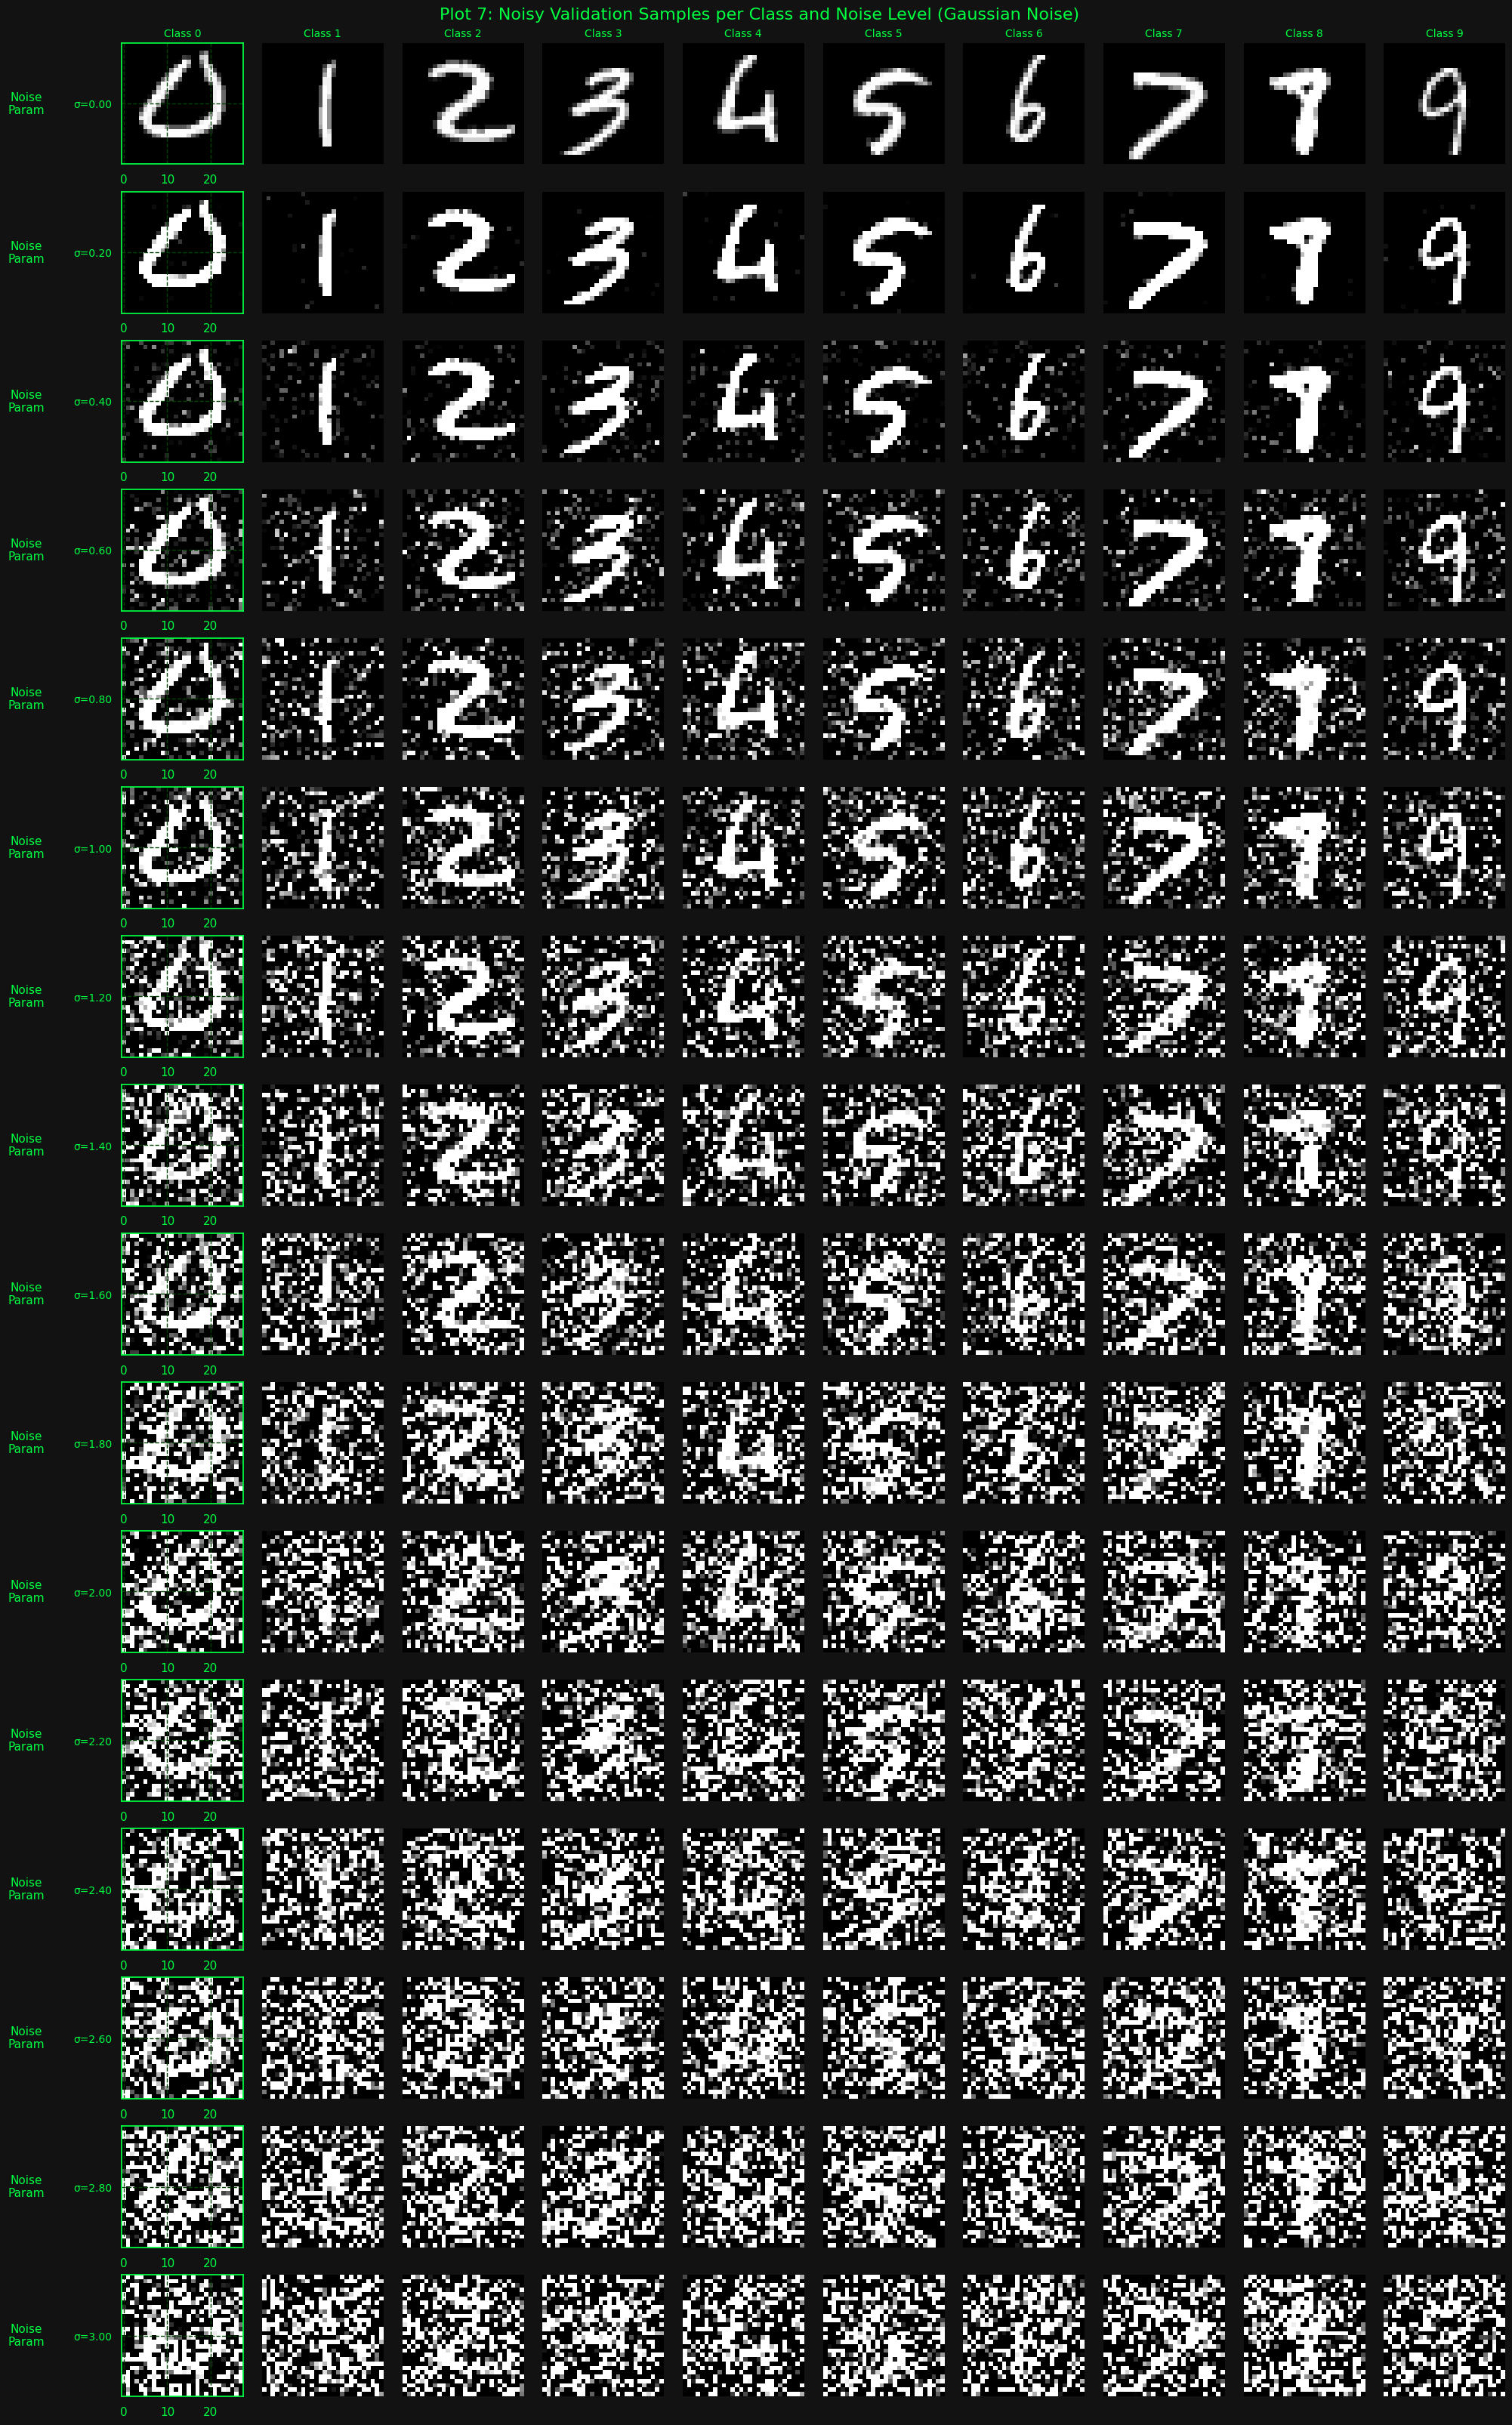

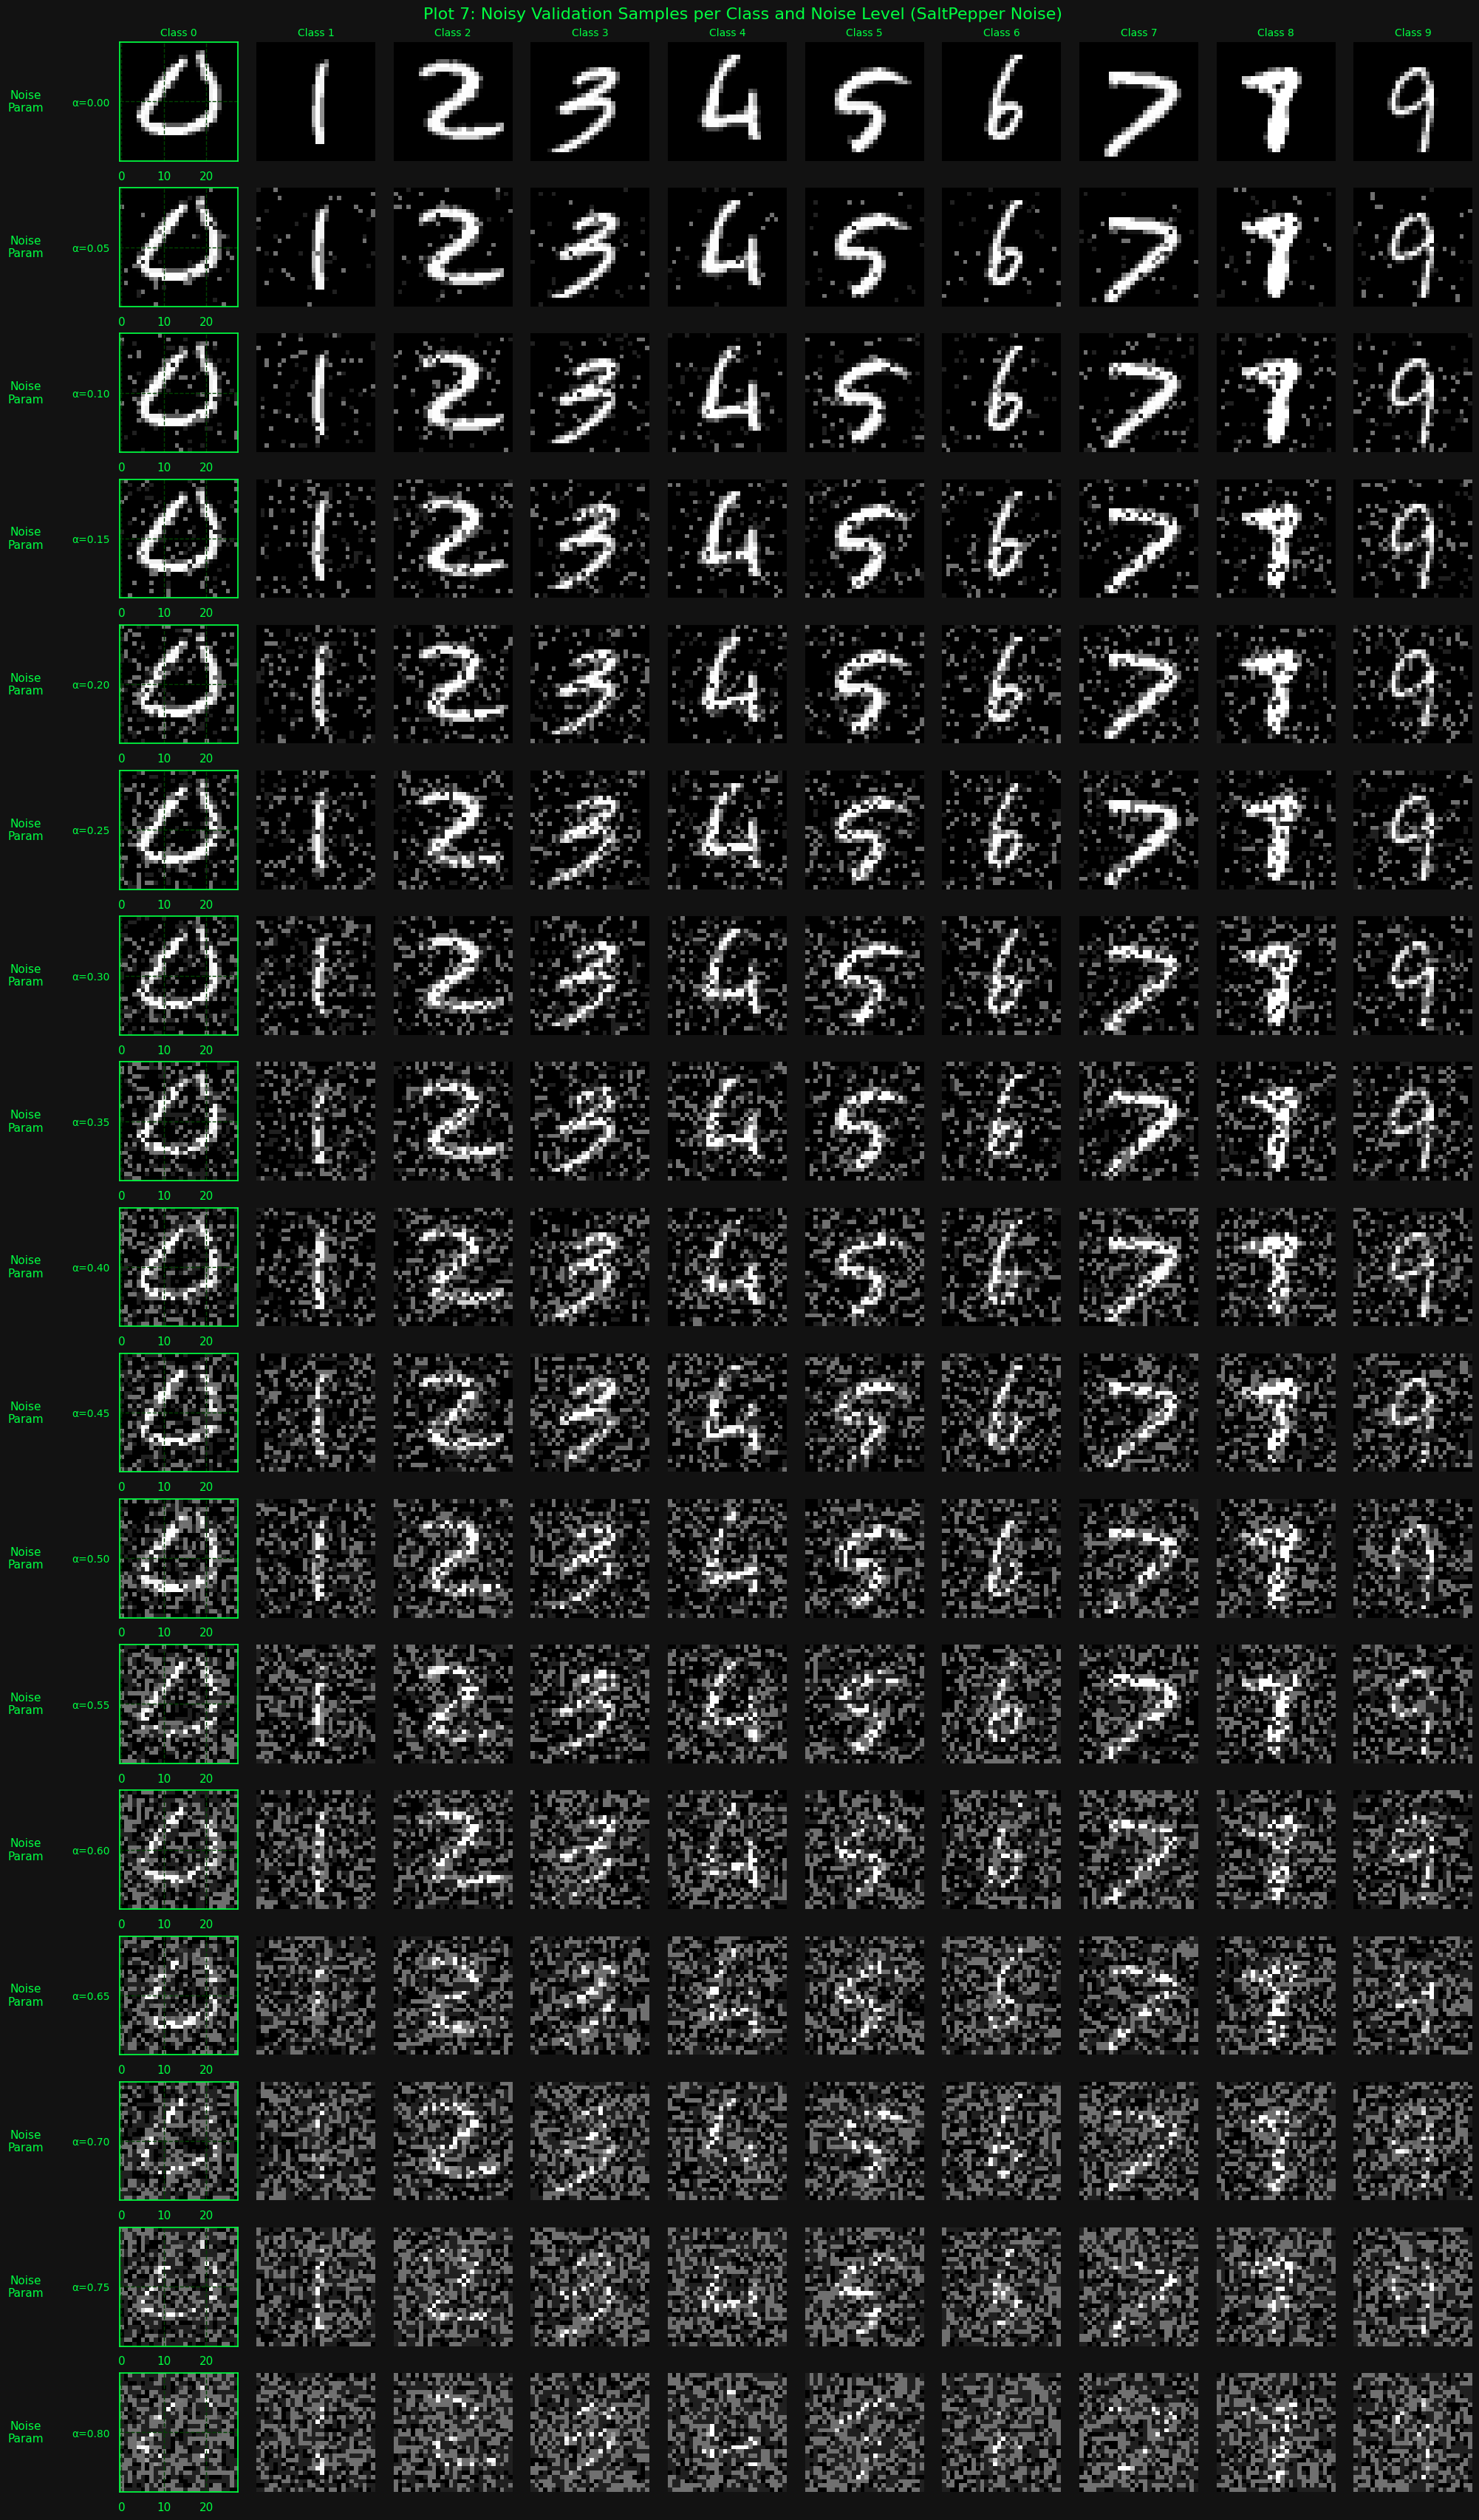

In [19]:
# === Cell 9: Q3.3 Noise Robustness Testing with Multiple Noise Types & Noisy Sample Plots

def noise_accuracy(model, loader, noise_param, noise_type='Gaussian'):
    """Compute accuracy under different noise types."""
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for X, y in loader:
            if noise_type == 'Gaussian':
                σ = noise_param
                if σ > 0:
                    Xn = torch.clamp(X + torch.randn_like(X) * σ, 0, 1)
                else:
                    Xn = X
            elif noise_type == 'SaltPepper':
                α = noise_param
                mask = torch.rand_like(X)
                Xn = X.clone()
                Xn[mask < (α/2)] = 0.0
                Xn[mask > (1 - α/2)] = 1.0
            else:
                Xn = X
            Xn, y = Xn.to(device), y.to(device)
            pred = model(Xn).argmax(dim=1)
            correct += (pred == y).sum().item()
            total += y.size(0)
    return correct / total

# Noise levels
gauss_levels = np.round(np.arange(0.0, 3.1, 0.2), 2).tolist()   # σ ∈ [0, 3]
sp_levels = np.round(np.arange(0.0, 0.81, 0.05), 2).tolist()    # α ∈ [0, 0.8]

# Validation set robustness
print("\033[96mNoise robustness on validation set:\033[0m")
results = {'Gaussian': [], 'SaltPepper': []}
for σ in gauss_levels:
    acc_bp = noise_accuracy(m_bp, val_loader, σ, 'Gaussian')
    acc_fa = noise_accuracy(m_fa, val_loader, σ, 'Gaussian')
    results['Gaussian'].append((acc_bp, acc_fa))
    print(f"  [Gaussian] σ = {σ:.2f} → BP: {acc_bp:.4f}, FA: {acc_fa:.4f}")

for α in sp_levels:
    acc_bp = noise_accuracy(m_bp, val_loader, α, 'SaltPepper')
    acc_fa = noise_accuracy(m_fa, val_loader, α, 'SaltPepper')
    results['SaltPepper'].append((acc_bp, acc_fa))
    print(f"  [SaltPepper] α = {α:.2f} → BP: {acc_bp:.4f}, FA: {acc_fa:.4f}")

# Test set robustness
print("\n\033[96mNoise robustness on test set:\033[0m")
test_results = {'Gaussian': [], 'SaltPepper': []}
for σ in gauss_levels:
    acc_bp = noise_accuracy(m_bp, test_loader, σ, 'Gaussian')
    acc_fa = noise_accuracy(m_fa, test_loader, σ, 'Gaussian')
    test_results['Gaussian'].append((acc_bp, acc_fa))
    print(f"  [Gaussian] σ = {σ:.2f} → BP: {acc_bp:.4f}, FA: {acc_fa:.4f}")

for α in sp_levels:
    acc_bp = noise_accuracy(m_bp, test_loader, α, 'SaltPepper')
    acc_fa = noise_accuracy(m_fa, test_loader, α, 'SaltPepper')
    test_results['SaltPepper'].append((acc_bp, acc_fa))
    print(f"  [SaltPepper] α = {α:.2f} → BP: {acc_bp:.4f}, FA: {acc_fa:.4f}")

# === Noisy Image Grid Plotting with Fancy Y-Axis

mean, std = 0.1307, 0.3081
def inv_normalize(t): return (t * std + mean).squeeze().cpu().numpy()

# One sample per class for consistent visualization
class_to_idx = {i: next(j for j, (x, y) in enumerate(val_ds) if y == i) for i in range(10)}

for noise_type, levels in [('Gaussian', gauss_levels), ('SaltPepper', sp_levels)]:
    fig, axes = plt.subplots(len(levels), 10, figsize=(20, 2 * len(levels)), constrained_layout=True)
    fig.suptitle(f"Plot 7: Noisy Validation Samples per Class and Noise Level ({noise_type} Noise)", fontsize=16, color="#00FF41")

    for row_idx, noise_param in enumerate(levels):
        for class_idx in range(10):
            sample_idx = class_to_idx[class_idx]
            img, _ = val_ds[sample_idx]
            if noise_type == 'Gaussian':
                Xn = img if noise_param == 0 else torch.clamp(img + torch.randn_like(img) * noise_param, 0, 1)
            else:  # Salt & Pepper
                α = noise_param
                mask = torch.rand_like(img)
                Xn = img.clone()
                Xn[mask < (α/2)] = 0
                Xn[mask > (1 - α/2)] = 1
            disp = inv_normalize(Xn)
            ax = axes[row_idx, class_idx]
            ax.imshow(disp, cmap='gray')
            ax.axis('off')
            if row_idx == 0:
                ax.set_title(f"Class {class_idx}", color="#00FF41", fontsize=10)

    # Remove all y-axis ticks first
    for ax_row in axes:
        for ax in ax_row:
            ax.set_yticks([])
            ax.set_ylabel('')

    # Add fancy noise labels only to leftmost column
    for row_idx, noise_param in enumerate(levels):
        ax = axes[row_idx, 0]
        ax.axis('on')
        ax.set_yticks([ax.get_ylim()[0] + (ax.get_ylim()[1] - ax.get_ylim()[0]) / 2])
        label = f"{'σ' if noise_type == 'Gaussian' else 'α'}={noise_param:.2f}"
        ax.set_yticklabels([label], color="#00FF41", fontsize=10)
        ax.yaxis.set_label_position("left")
        ax.set_ylabel("Noise\nParam", color="#00FF41", fontsize=11, rotation=0, labelpad=45, va='center')

    plt.show()
    plt.close(fig)


In [20]:
# === Cell 10: Q7 - Bias & Variance of Weight Updates (on TEST SET)
m_bp, m_fa, B = make_models()  # fresh models
opt_bp = optim.Adam(m_bp.parameters(), lr=LR)
crit = nn.CrossEntropyLoss()

# layers to track
layers = [name for name, _ in m_bp.named_parameters() if 'weight' in name or 'bias' in name]

# initialize storage
bias_curve = {layer: [] for layer in layers}
snr_curve  = {layer: [] for layer in layers}

def normalize_vec(v):
    norm = np.linalg.norm(v)
    return v / norm if norm > 1e-12 else v

for epoch in range(EPOCHS):
    # per-layer accumulators
    stats = {
        layer: {
            'sum_bp': None, 'sum_fa': None,
            'sq_bp': None,  'sq_fa': None,
            'cnt': 0,
            'cosines': []  # track per-batch cosine for error bars
        }
        for layer in layers
    }

    # iterate TEST set (limit to first 40 batches for speed)
    for i, (X, y) in enumerate(test_loader):
        if i >= 40:
            break
        X, y = X.to(device), y.to(device)

        # save before‐update
        before_bp = {n: p.clone() for n, p in m_bp.named_parameters() if n in layers}
        before_fa = {n: p.clone() for n, p in m_fa.named_parameters() if n in layers}

        # single‐batch updates
        bp_update(m_bp, X, y, opt_bp, crit)
        fa_update(m_fa, X, y, B)

        # compute update vectors
        with torch.no_grad():
            for layer in layers:
                d_bp = (m_bp.state_dict()[layer] - before_bp[layer]).flatten().cpu().numpy()
                d_fa = (m_fa.state_dict()[layer] - before_fa[layer]).flatten().cpu().numpy()

                s = stats[layer]
                # init arrays once
                if s['sum_bp'] is None:
                    s['sum_bp'] = np.zeros_like(d_bp)
                    s['sum_fa'] = np.zeros_like(d_fa)
                    s['sq_bp']  = np.zeros_like(d_bp)
                    s['sq_fa']  = np.zeros_like(d_fa)

                # accumulate for mean & variance
                s['sum_bp'] += d_bp
                s['sum_fa'] += d_fa
                s['sq_bp']  += d_bp**2
                s['sq_fa']  += d_fa**2
                s['cnt']    += 1

                # track cosine similarity per batch
                μ_bp_n = normalize_vec(d_bp)
                μ_fa_n = normalize_vec(d_fa)
                s['cosines'].append(np.dot(μ_bp_n, μ_fa_n))

    # now compute epoch‐level bias & SNR (and std for bias)
    for layer in layers:
        s = stats[layer]
        cnt = s['cnt']
        μ_bp = s['sum_bp'] / cnt
        μ_fa = s['sum_fa'] / cnt

        # bias = cosine( mean_bp, mean_fa )
        μ_bp_n = normalize_vec(μ_bp)
        μ_fa_n = normalize_vec(μ_fa)
        bias = float(np.dot(μ_bp_n, μ_fa_n))
        bias_curve[layer].append(bias)
        # standard deviation of batch‐wise cosine (for error band)
        bias_std = float(np.std(s['cosines']))

        # SNR
        var_bp = s['sq_bp']/cnt - μ_bp**2
        var_fa = s['sq_fa']/cnt - μ_fa**2
        snr_bp = float(np.dot(μ_bp, μ_bp) / (np.sum(var_bp) + 1e-12))
        snr_fa = float(np.dot(μ_fa, μ_fa) / (np.sum(var_fa) + 1e-12))
        snr_curve[layer].append((snr_bp, snr_fa, bias_std))

    print(f"[Q7] Epoch {epoch+1}/{EPOCHS} → Bias & SNR computed on TEST set")


[Q7] Epoch 1/8 → Bias & SNR computed on TEST set
[Q7] Epoch 2/8 → Bias & SNR computed on TEST set
[Q7] Epoch 3/8 → Bias & SNR computed on TEST set
[Q7] Epoch 4/8 → Bias & SNR computed on TEST set
[Q7] Epoch 5/8 → Bias & SNR computed on TEST set
[Q7] Epoch 6/8 → Bias & SNR computed on TEST set
[Q7] Epoch 7/8 → Bias & SNR computed on TEST set
[Q7] Epoch 8/8 → Bias & SNR computed on TEST set


In [21]:

# === Cell 11: Latent Representation Similarity + Weight Norms
latent_sims = []
bp_weight_norms = {n: [] for n in layers if 'weight' in n}
fa_weight_norms = {n: [] for n in layers if 'weight' in n}

for epoch in range(EPOCHS):
    with torch.no_grad():
        sample_X, _ = next(iter(train_loader))
        sample_X = sample_X.to(device)

        h_bp = m_bp.net[2](m_bp.net[1](sample_X.view(sample_X.size(0), -1)))
        h_fa = m_fa.net[2](m_fa.net[1](sample_X.view(sample_X.size(0), -1)))

        sim = F.cosine_similarity(h_bp, h_fa, dim=1).mean().item()
        latent_sims.append(sim)

        for n in bp_weight_norms:
            bp_weight_norms[n].append(m_bp.state_dict()[n].norm().item())
            fa_weight_norms[n].append(m_fa.state_dict()[n].norm().item())


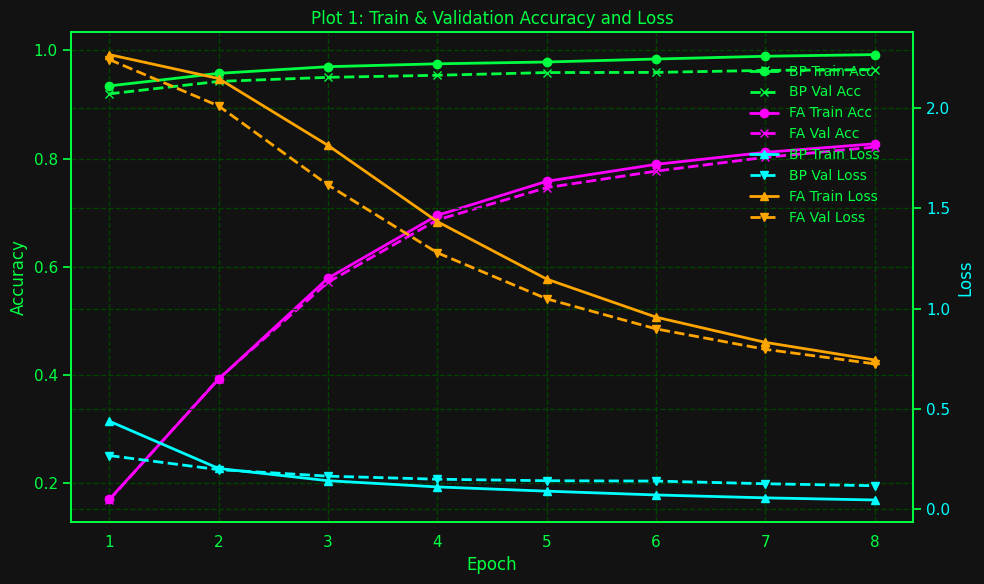

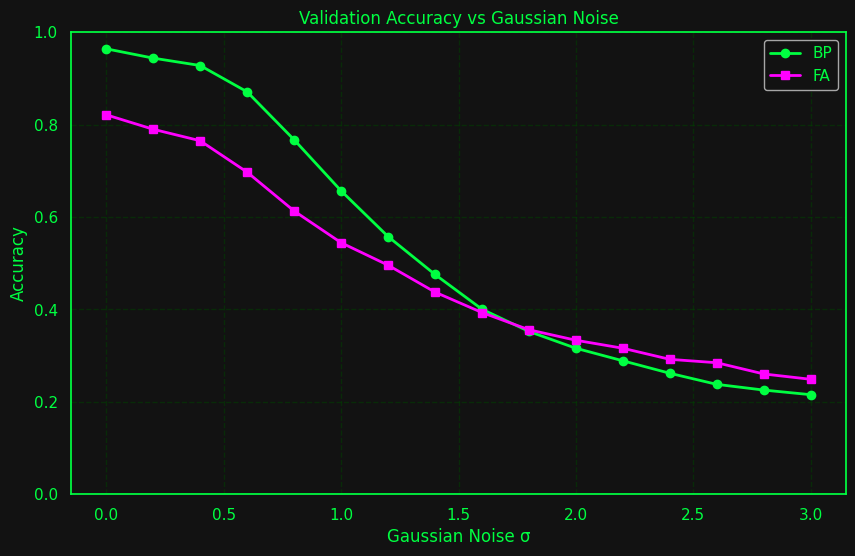

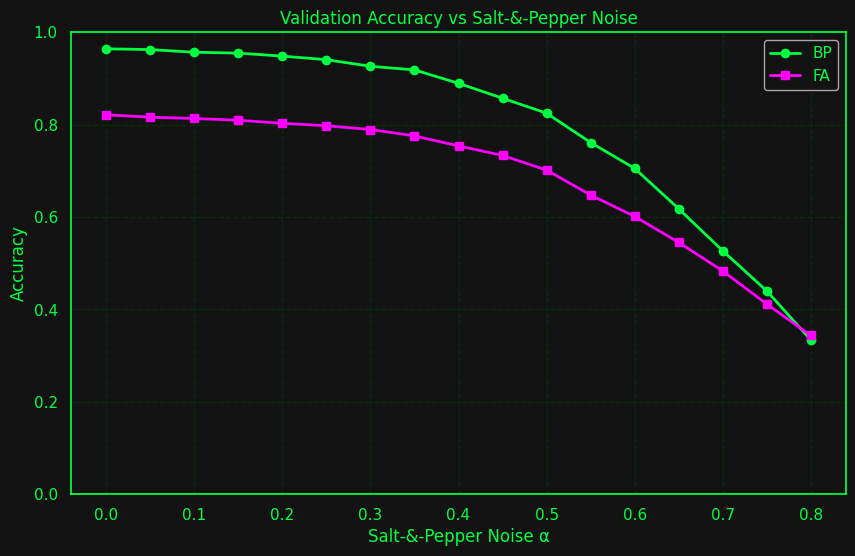

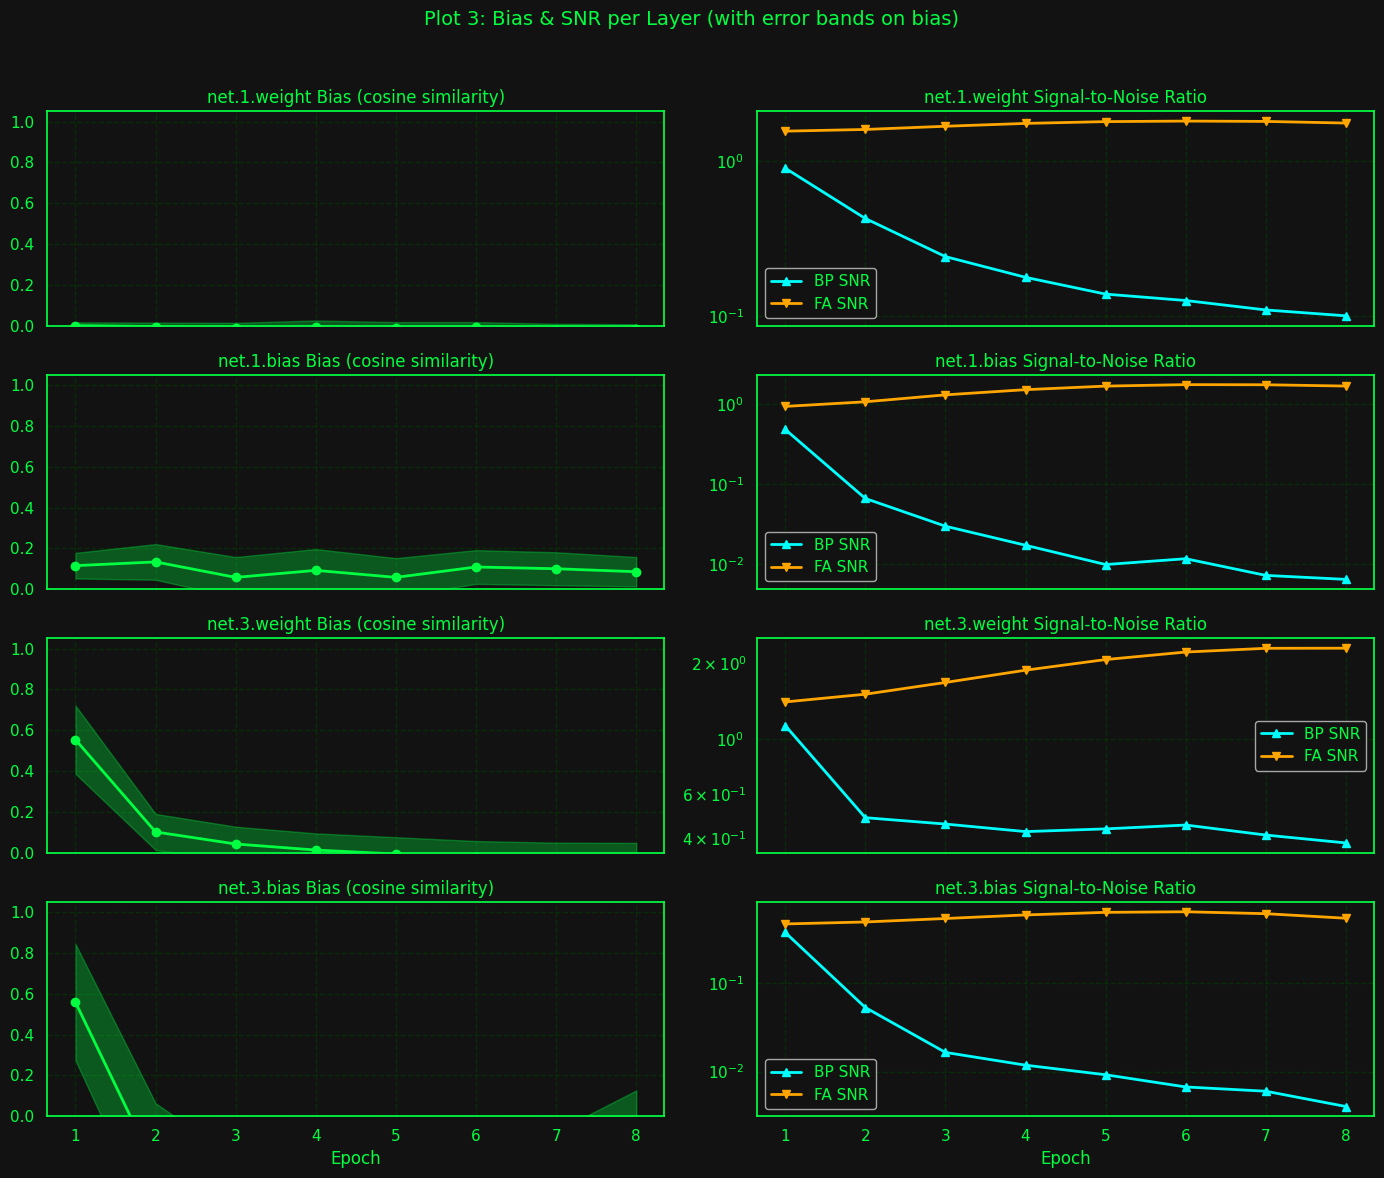

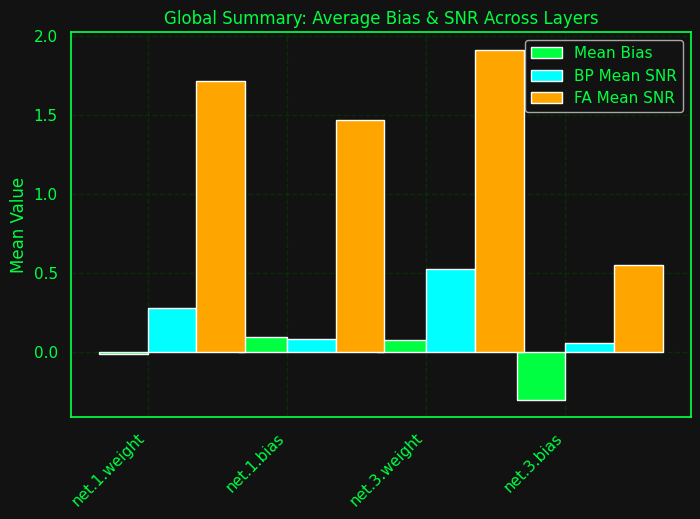

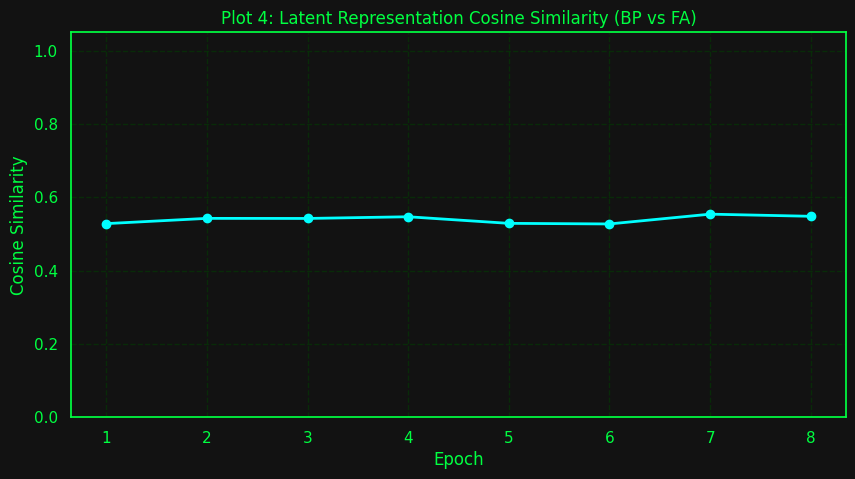

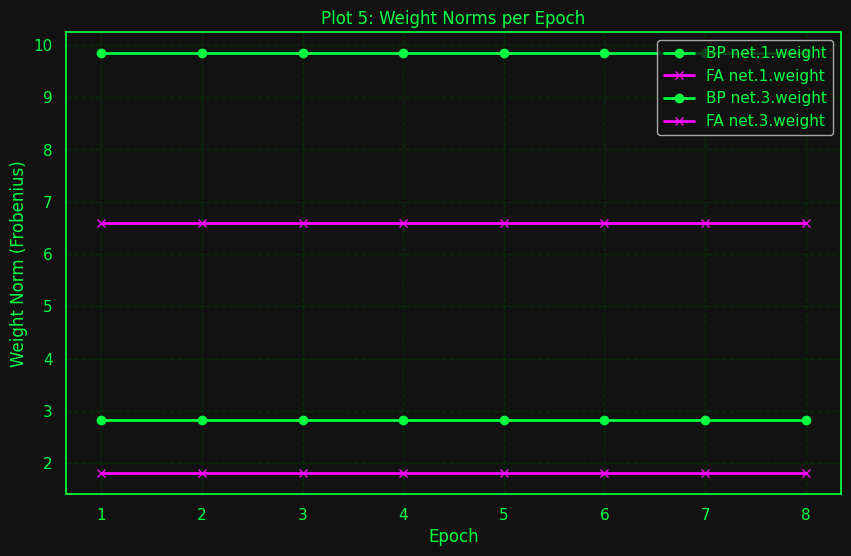

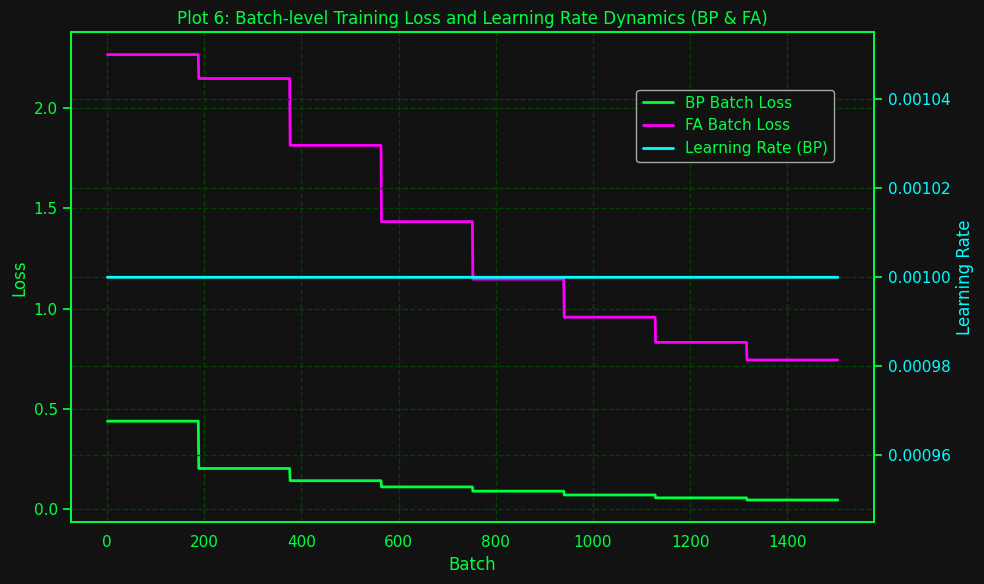


All plots (1–6) saved to: /mnt/data/nma_plots


In [22]:
# === Cell 12: Plotting (UPDATED - Plot Numbers Added)







import matplotlib.ticker as ticker

def save_plot(fig, name):
    fig.savefig(f"{plot_dir}/{name}.png", dpi=300)
    fig.savefig(f"{plot_dir}/{name}.svg")

# --- Plot 1: Accuracy & Loss vs Epoch
fig, ax1 = plt.subplots(figsize=(10, 6))
epochs = np.arange(1, EPOCHS + 1)

ax1.set_xlabel("Epoch")
ax1.set_ylabel("Accuracy", color="#00FF41")
ax1.plot(epochs, metrics['bp']['train_acc'], label="BP Train Acc", color="#00FF41", marker='o')
ax1.plot(epochs, metrics['bp']['val_acc'], label="BP Val Acc", color="#00FF41", linestyle='--', marker='x')
ax1.plot(epochs, metrics['fa']['train_acc'], label="FA Train Acc", color="#FF00FF", marker='o')
ax1.plot(epochs, metrics['fa']['val_acc'], label="FA Val Acc", color="#FF00FF", linestyle='--', marker='x')
ax1.tick_params(axis='y', labelcolor="#00FF41")

ax2 = ax1.twinx()
ax2.set_ylabel("Loss", color="#00FFFF")
ax2.plot(epochs, metrics['bp']['train_loss'], label="BP Train Loss", color="#00FFFF", marker='^')
ax2.plot(epochs, metrics['bp']['val_loss'], label="BP Val Loss", color="#00FFFF", linestyle='--', marker='v')
ax2.plot(epochs, metrics['fa']['train_loss'], label="FA Train Loss", color="#FFA500", marker='^')
ax2.plot(epochs, metrics['fa']['val_loss'], label="FA Val Loss", color="#FFA500", linestyle='--', marker='v')
ax2.tick_params(axis='y', labelcolor="#00FFFF")

ax1.set_title("Plot 1: Train & Validation Accuracy and Loss")
fig.legend(loc="upper right", bbox_to_anchor=(0.9, 0.9), fontsize=10, frameon=False)
fig.tight_layout()
save_plot(fig, "plot01_train_val_acc_loss")
plt.show()
plt.close(fig)



# Plot Gaussian robustness
fig, ax = plt.subplots(figsize=(10,6))
g_bp = [b for b,_ in results['Gaussian']]
g_fa = [f for _,f in results['Gaussian']]
ax.plot(gauss_levels, g_bp, '-o', label='BP', color="#00FF41")
ax.plot(gauss_levels, g_fa, '-s', label='FA', color="#FF00FF")
ax.set_xlabel("Gaussian Noise σ")
ax.set_ylabel("Accuracy")
ax.set_title("Validation Accuracy vs Gaussian Noise")
ax.set_ylim(0,1)
ax.grid(True, linestyle='--', alpha=0.5)
ax.legend()
plt.show()
plt.close(fig)

# Plot Salt‑&‑Pepper robustness
fig, ax = plt.subplots(figsize=(10,6))
sp_bp = [b for b,_ in results['SaltPepper']]
sp_fa = [f for _,f in results['SaltPepper']]
ax.plot(sp_levels, sp_bp, '-o', label='BP', color="#00FF41")
ax.plot(sp_levels, sp_fa, '-s', label='FA', color="#FF00FF")
ax.set_xlabel("Salt‑&‑Pepper Noise α")
ax.set_ylabel("Accuracy")
ax.set_title("Validation Accuracy vs Salt‑&‑Pepper Noise")
ax.set_ylim(0,1)
ax.grid(True, linestyle='--', alpha=0.5)
ax.legend()
plt.show()
plt.close(fig)


# === Plot 3 (UPDATED) — Bias & SNR with Error Bands and Global Summary
import matplotlib.ticker as ticker

# prepare a global summary too
global_bias = []
global_snr_bp = []
global_snr_fa = []

# set up subplots
fig, axs = plt.subplots(len(layers), 2, figsize=(14, 3*len(layers)), sharex=True)
for i, layer in enumerate(layers):
    # unpack per‐epoch values + std
    bias_vals = bias_curve[layer]
    stds      = [entry[2] for entry in snr_curve[layer]]  # stored bias_std in snr_curve
    snr_bp    = [entry[0] for entry in snr_curve[layer]]
    snr_fa    = [entry[1] for entry in snr_curve[layer]]

    # bias + error band
    epochs = np.arange(1, EPOCHS+1)
    axs[i,0].plot(epochs, bias_vals, marker='o', color="#00FF41")
    axs[i,0].fill_between(epochs,
                          np.array(bias_vals)-np.array(stds),
                          np.array(bias_vals)+np.array(stds),
                          color="#00FF41", alpha=0.3)
    axs[i,0].set_title(f"{layer} Bias (cosine similarity)")
    axs[i,0].set_ylim(0,1.05)
    axs[i,0].grid(True, linestyle='--', alpha=0.5)

    # SNR (log scale)
    axs[i,1].plot(epochs, snr_bp, label="BP SNR", marker='^', color="#00FFFF")
    axs[i,1].plot(epochs, snr_fa, label="FA SNR", marker='v', color="#FFA500")
    axs[i,1].set_yscale('log')
    axs[i,1].set_title(f"{layer} Signal‑to‑Noise Ratio")
    axs[i,1].legend()
    axs[i,1].grid(True, linestyle='--', alpha=0.5)

    # accumulate for global
    global_bias.append(np.mean(bias_vals))
    global_snr_bp.append(np.mean(snr_bp))
    global_snr_fa.append(np.mean(snr_fa))

# labels
for ax in axs[-1,:]:
    ax.set_xlabel("Epoch")
fig.suptitle("Plot 3: Bias & SNR per Layer (with error bands on bias)", fontsize=14)
fig.tight_layout(rect=[0,0,1,0.96])
save_plot(fig, "plot03_bias_snr_per_layer")
plt.show()
plt.close(fig)

# === GLOBAL SUMMARY PLOT ===
fig, ax = plt.subplots(figsize=(8,5))
layers_idx = np.arange(len(layers))
width = 0.35

ax.bar(layers_idx - width/2, global_bias, width, label="Mean Bias", color="#00FF41")
ax.bar(layers_idx + width/2, global_snr_bp, width, label="BP Mean SNR", color="#00FFFF")
ax.bar(layers_idx + 1.5*width, global_snr_fa, width, label="FA Mean SNR", color="#FFA500")

ax.set_xticks(layers_idx)
ax.set_xticklabels(layers, rotation=45, ha='right')
ax.set_ylabel("Mean Value")
ax.set_title("Global Summary: Average Bias & SNR Across Layers")
ax.legend()
ax.grid(True, linestyle='--', alpha=0.5)
save_plot(fig, "plot03_global_summary")
plt.show()
plt.close(fig)


# --- Plot 4: Latent Representation Similarity
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(epochs, latent_sims, color="#00FFFF", marker='o')
ax.set_title("Plot 4: Latent Representation Cosine Similarity (BP vs FA)")
ax.set_xlabel("Epoch")
ax.set_ylabel("Cosine Similarity")
ax.set_ylim(0, 1.05)
ax.grid(True, linestyle='--', alpha=0.5)
save_plot(fig, "plot04_latent_representation_similarity")
plt.show()
plt.close(fig)

# --- Plot 5: Weight Norms (Hidden Layer Weights)
fig, ax = plt.subplots(figsize=(10, 6))
for layer in bp_weight_norms:
    ax.plot(epochs, bp_weight_norms[layer], label=f"BP {layer}", color="#00FF41", marker='o')
    ax.plot(epochs, fa_weight_norms[layer], label=f"FA {layer}", color="#FF00FF", marker='x')

ax.set_title("Plot 5: Weight Norms per Epoch")
ax.set_xlabel("Epoch")
ax.set_ylabel("Weight Norm (Frobenius)")
ax.legend()
ax.grid(True, linestyle='--', alpha=0.5)
save_plot(fig, "plot05_weight_norms")
plt.show()
plt.close(fig)

# --- Plot 6: Batch-Level Training Loss & Learning Rate
fig, ax1 = plt.subplots(figsize=(10,6))
ax1.plot(range(1, len(metrics['bp']['batch_loss'])+1), metrics['bp']['batch_loss'], color="#00FF41", label="BP Batch Loss")
ax1.plot(range(1, len(metrics['fa']['batch_loss'])+1), metrics['fa']['batch_loss'], color="#FF00FF", label="FA Batch Loss")
ax1.set_xlabel("Batch")
ax1.set_ylabel("Loss", color="#00FF41")
ax1.tick_params(axis='y', labelcolor="#00FF41")

ax2 = ax1.twinx()
ax2.plot(range(1, len(metrics['bp']['batch_lr'])+1), metrics['bp']['batch_lr'], color="#00FFFF", label="Learning Rate (BP)")
ax2.set_ylabel("Learning Rate", color="#00FFFF")
ax2.tick_params(axis='y', labelcolor="#00FFFF")

ax1.set_title("Plot 6: Batch-level Training Loss and Learning Rate Dynamics (BP & FA)")
fig.legend(loc="upper right", bbox_to_anchor=(0.85, 0.85))
fig.tight_layout()
save_plot(fig, "plot06_batch_loss_lr_dynamics")
plt.show()
plt.close(fig)

print(f"\nAll plots (1–6) saved to: {plot_dir}")
